In [1]:
import sys
sys.path.append("../../")

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *

In [3]:
data=pl.read_csv("errorAnalysed.csv").drop("index")
data.head()

car_ID,cylindernumber,carvolume,enginepower,averagempg,price
i64,i64,f64,f64,f64,f64
1,0,19644.653443,2.503605e8,23.7,13495.0
2,0,19644.653443,2.503605e8,23.7,16500.0
3,1,20223.0,3.136672e8,22.15,16500.0
4,0,21487.178932,1.9506531e8,26.7,13950.0
5,1,21465.713738,2.744038e8,19.8,17450.0


In [4]:
data.shape

(178, 6)

12% of overall data points for filtered out

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge,Lasso
from sklearn.model_selection import KFold,cross_val_score,cross_val_predict,train_test_split,GridSearchCV
from sklearn.metrics import mean_absolute_error,r2_score
X=data.drop('price',"car_ID").to_pandas()
y=data['price'].to_pandas()
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

# Lasso regression

Mean Absolute Error: 1821.0635938371283
R-squared holdout: 0.86469444846853


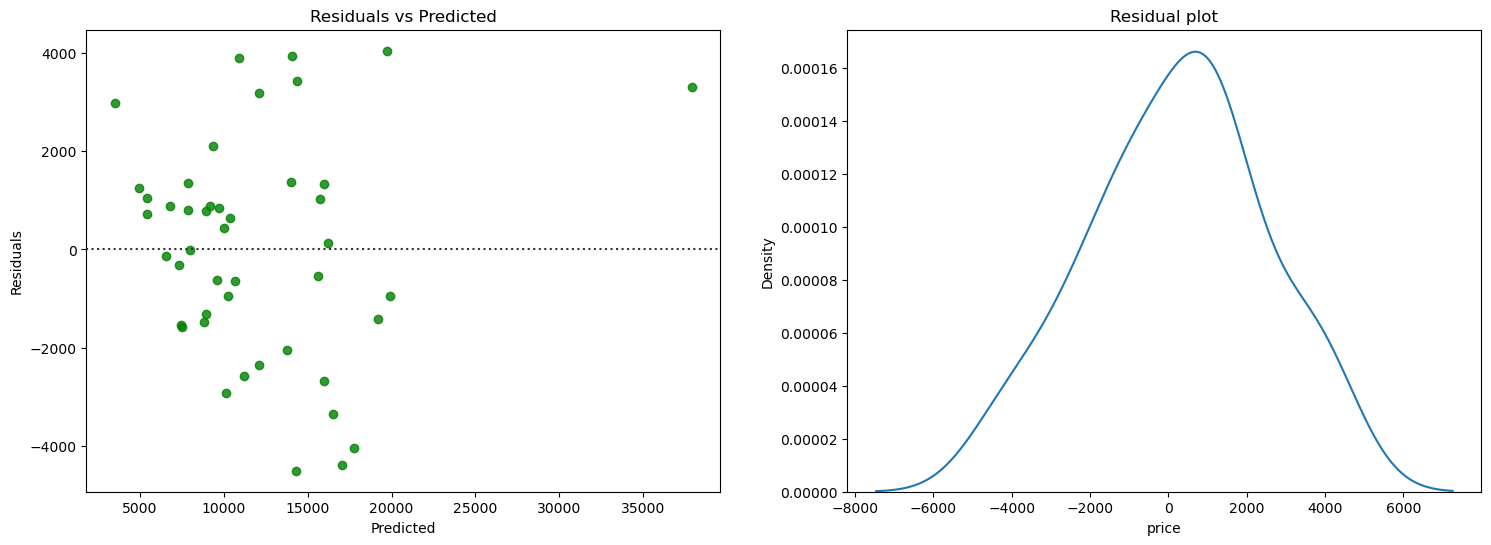

In [7]:
lasso_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('regressor', Lasso())
])
kf = KFold(n_splits=3)
param_grid = {'regressor__alpha': np.logspace(-3, 3, 100)}

grid_search = GridSearchCV(lasso_pipe, param_grid, cv=kf)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['regressor__alpha']

lasso_pipe.set_params(regressor__alpha=best_alpha)
lasso_pipe.fit(X_train, y_train)

cv_scores = cross_val_score(lasso_pipe, X_train, y_train, cv=kf)

predictions = cross_val_predict(lasso_pipe, X_test, y_test, cv=kf)
residuals = y_test - predictions
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'Mean Absolute Error: {mae}')
print(f'R-squared holdout: {r2}')
# Plotting residuals
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(18, 6))
sns.residplot(x=predictions, y=residuals, color='g', ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals, ax=ax2)
ax2.set_title("Residual plot")
plt.show()

# Ridge regression

Mean Absolute Error: 1838.642972027784
R-squared holdout: 0.861144833797493


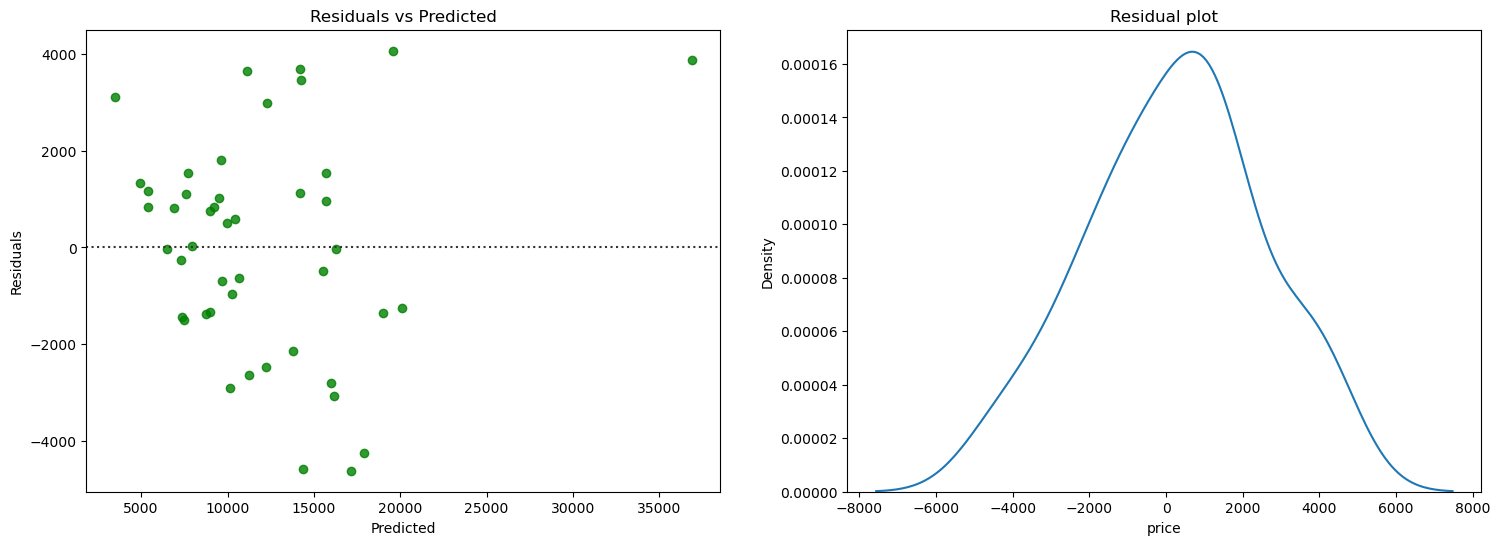

In [8]:
ridge_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('regressor', Ridge())
])
kf = KFold(n_splits=3)
param_grid = {'regressor__alpha': np.logspace(-3, 3, 100)}

grid_search = GridSearchCV(ridge_pipe, param_grid, cv=kf)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['regressor__alpha']

ridge_pipe.set_params(regressor__alpha=best_alpha)
ridge_pipe.fit(X_train, y_train)
cv_scores = cross_val_score(ridge_pipe, X_train, y_train, cv=kf)

predictions = cross_val_predict(ridge_pipe, X_test, y_test, cv=kf)
residuals = y_test - predictions
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'Mean Absolute Error: {mae}')
print(f'R-squared holdout: {r2}')
# Plotting residuals
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(18, 6))
sns.residplot(x=predictions, y=residuals, color='g', ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals, ax=ax2)
ax2.set_title("Residual plot")
plt.show()

# All works same

Mean Absolute Error: 1827.5303830497664
R-squared holdout: 0.8636811072377506


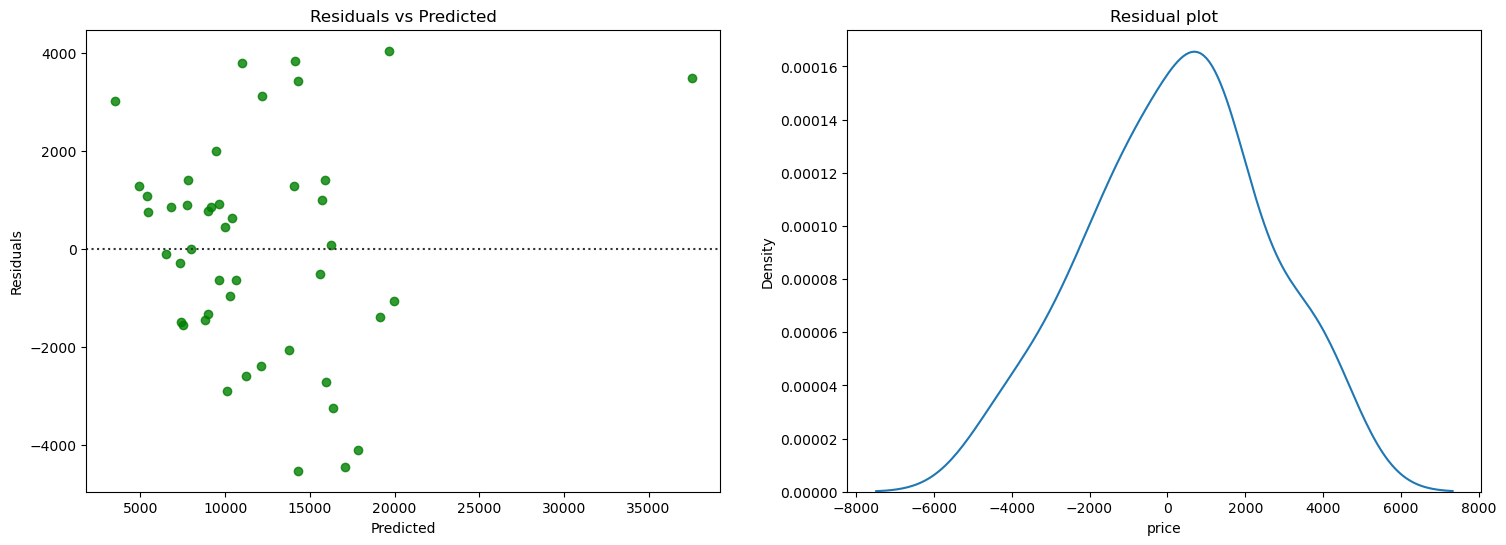

In [9]:
from sklearn.linear_model import ElasticNet

elastic_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('regressor', ElasticNet())
])

kf = KFold(n_splits=3)
param_grid = {'regressor__alpha': np.logspace(-3, 3, 100),
              'regressor__l1_ratio': np.arange(0.2,0.8,0.1)}
grid_search = GridSearchCV(elastic_pipe, param_grid, cv=kf)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['regressor__alpha']
best_l1_ratio = grid_search.best_params_['regressor__l1_ratio']
elastic_pipe.set_params(regressor__alpha=best_alpha)
elastic_pipe.set_params(regressor__l1_ratio=best_l1_ratio)
elastic_pipe.fit(X_train, y_train)
cv_scores = cross_val_score(elastic_pipe, X_train, y_train, cv=kf)

predictions = cross_val_predict(elastic_pipe, X_test, y_test, cv=kf)
residuals = y_test - predictions
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'Mean Absolute Error: {mae}')
print(f'R-squared holdout: {r2}')

# Plotting residuals

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(18, 6))
sns.residplot(x=predictions, y=residuals, color='g', ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals, ax=ax2)
ax2.set_title("Residual plot")
plt.show()

# Elastic net regressor work better

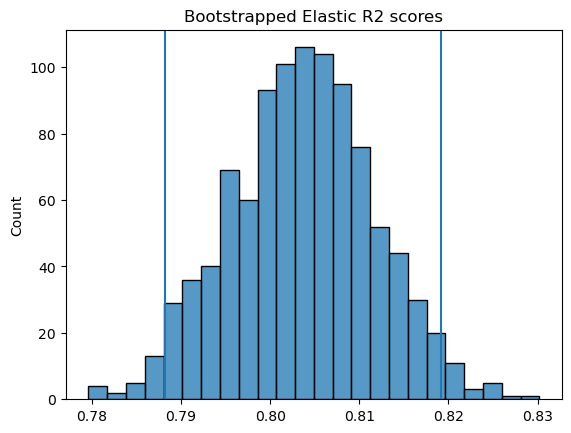

Mean Absolute Elasticnet Error: 1818.7305673182966
Median Absolute Elasticnet Error: 1784.514439419824
Average Mean Elasticnet R-squared: 0.8032183952489305
Avg Median Elasticnet R-squared: 0.8181300452295485
95% Confidence Interval for R-squared: (0.7881952663342757, 0.8191874002812256)


In [10]:
def avg_elastic(X, y, num_iterations=100, num_bootstrap=1000):
    elastic_errors = []
    elastic_scores = []
    
    for i in range(num_iterations):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0 + i)
        kf = KFold(n_splits=3)
        
        elastic_pipe.fit(X_train, y_train)
        
        predictions = cross_val_predict(elastic_pipe, X_test, y_test, cv=kf)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        
        elastic_errors.append(mae)
        elastic_scores.append(r2)
        
    # Convert lists to numpy arrays for easier manipulation
    elastic_scores = np.array(elastic_scores)
    
    # Calculate the mean and median errors and scores
    mean_error = np.mean(elastic_errors)
    median_error = np.median(elastic_errors)
    mean_r2 = np.mean(elastic_scores)
    median_r2 = np.median(elastic_scores)
    
    # Bootstrap for confidence intervals
    bootstrapped_r2 = []
    n = len(elastic_scores)
    for _ in range(num_bootstrap):
        sample_indices = np.random.choice(np.arange(n), size=n, replace=True)
        sample_r2 = elastic_scores[sample_indices]
        bootstrapped_r2.append(np.mean(sample_r2))
    
    lower_bound = np.percentile(bootstrapped_r2, 2.5)
    upper_bound = np.percentile(bootstrapped_r2, 97.5)
    sns.histplot(bootstrapped_r2)
    plt.title("Bootstrapped Elastic R2 scores")
    plt.axvline(lower_bound)
    plt.axvline(upper_bound)
    plt.show()
    return elastic_scores, mean_error, median_error, mean_r2, median_r2, lower_bound, upper_bound

# Assuming X and y are defined
elastic_scores, elastic_mae_mean, elastic_mae_median, elastic_r2_mean, elastic_r2_median, lower_bound, upper_bound = avg_elastic(X, y)

print(f'Mean Absolute Elasticnet Error: {elastic_mae_mean}')
print(f'Median Absolute Elasticnet Error: {elastic_mae_median}')
print(f'Average Mean Elasticnet R-squared: {elastic_r2_mean}')
print(f'Avg Median Elasticnet R-squared: {elastic_r2_median}')
print(f'95% Confidence Interval for R-squared: ({lower_bound}, {upper_bound})')

# Started absolute error : 4182
# End absolute error : 1535

### We still have some HeteroSkedacity due to nature of data (low scatter at low price and more at high price) ,we could cover those variance using some other regression techniques

### We still have Multicollinearity in the data